**CURSO**: *Machine Learning* en Geociencias<br />
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from several sources such as [Mar Kramer](https://github.com/Mark-Kramer/Case-Studies-Python/blob/master/09.ipynb). Every effort has been made to trace copyright holders of the materials used in this notebook. The author apologizes for any unintentional omissions and would be pleased to add an acknowledgment in future editions.

In [1]:
# Import the usual suspects ...
from scipy.io import loadmat                    # To load .mat files
from pylab import *                             # Import plotting and numerical functions
rcParams['figure.figsize']=(12,3) 

# ... and some additional modules.
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
from statsmodels.genmod.families.links import identity, log
from scipy.stats import chi2
from statsmodels.distributions.empirical_distribution import ECDF
from pandas import DataFrame as df

Un colaborador se ha puesto en contacto con nosotros para discutir un nuevo experimento que ha realizado. Como parte de este experimento, ha implantado un pequeño conjunto de electrodos en el hipocampo de una rata y ha entrenado a la rata para realizar una tarea espacial simple: correr de un lado a otro a lo largo de un laberinto lineal. Durante esta tarea, nuestro colaborador cree haber registrado la actividad de disparo de una célula de lugar, una célula cuya actividad es específica de una posición. Nos ha pedido ayuda para caracterizar estos datos de tren de picos y apoyar (o refutar) la noción de que la célula observada es una célula de lugar. Ha accedido a proporcionarnos los datos observados del tren de picos y la posición de la rata en función del tiempo, registrados durante unos minutos del experimento.

Nuestro objetivo es caracterizar las propiedades de la célula observada mientras la rata corre de un lado a otro en el laberinto lineal. Se sabe que la actividad de disparo en estas células está relacionada con otras variables, como la velocidad y la dirección de la cabeza de la rata. Aquí, nos enfocamos en modelar la relación entre la trayectoria de movimiento de la rata y la actividad de disparo observada. Al hacerlo, seleccionamos un modelo mediante un proceso iterativo de ajuste, evaluación y refinamiento del modelo.

In [ ]:
import pip
pip.main(['install','urllib2'])

In [18]:
import requests
url = 'https://github.com/Mark-Kramer/Case-Studies-Python/raw/master/matfiles/spikes-1.mat'
r = requests.get(url, allow_redirects=True)
open('spikles-1.mat', 'wb').write(r.content)

1761663

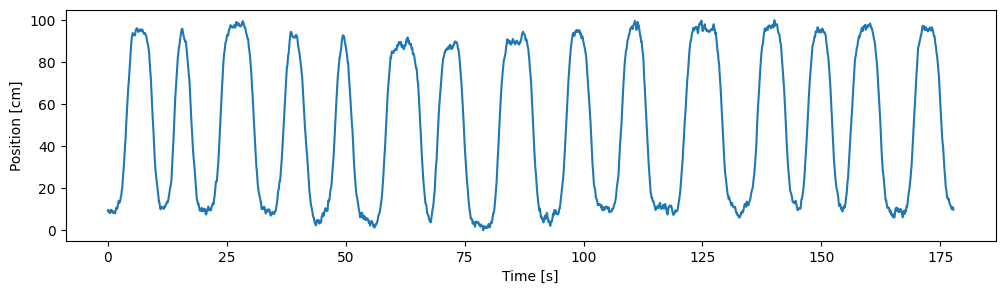

In [19]:
data = loadmat("spikles-1.mat")  # Load the data,
t = data['t'][:,0]              # Extract the t variable,
X = data['X'][:,0]              # Extract the X variable,
plot(t, X)                      # ... and plot it.
xlabel('Time [s]')
ylabel('Position [cm]')
show()

El gráfico muestra que la rata corre de un lado a otro de manera consistente, realizando aproximadamente 15 pasadas durante los 3 minutos de grabación. También observamos que la rata se mueve bastante rápido en cada pasada, pero pasa una gran cantidad de tiempo en ambos extremos de la pista (cerca de la posición 0 cm o 100 cm) antes de girar y continuar.

A continuación, nos gustaría graficar la actividad de disparo en relación con la trayectoria de movimiento de la rata. Sin embargo, no podemos simplemente graficar el vector X contra el vector spiketimes; estos vectores tienen longitudes diferentes. La longitud de X es la misma que la longitud de t, el número total de intervalos de tiempo de 1 ms en la grabación (177,761 intervalos de tiempo). La longitud de spiketimes es el número total de picos que ocurrieron durante la duración de la grabación: 220 picos. Por lo tanto, el primer paso para visualizar la actividad de disparo específica del lugar es usar spiketimes para crear un nuevo vector, del mismo tamaño que X, que indique si se produjo un pico en cada intervalo de tiempo. Llamaremos a este vector spiketrain, y contendrá un 1 para cada intervalo de tiempo donde ocurre un pico y un 0 para cada intervalo de tiempo que no tiene un pico.

**Pregunta:** ¿Cómo construirías el vector spiketrain? ¿Puedes pensar en múltiples maneras de construir el mismo vector?

**Respuesta:** Podríamos usar un bucle *for* para recorrer cada intervalo de tiempo y decidir si ocurrió un pico. Un enfoque más eficiente es darse cuenta de que este cálculo se puede realizar como un histograma y usar la función `histogram` de `numpy`. Hay muchas otras formas de calcular este mismo vector.

In [20]:
spiketimes = data['spiketimes']
n_bins = len(t)
# Histogram spikes into bins centered at times t:
spiketrain = histogram(spiketimes, 
                         bins = n_bins, 
                         range = (t[0], t[-1]))[0] 

Ahora podemos graficar la posición y el tren de picos juntos.

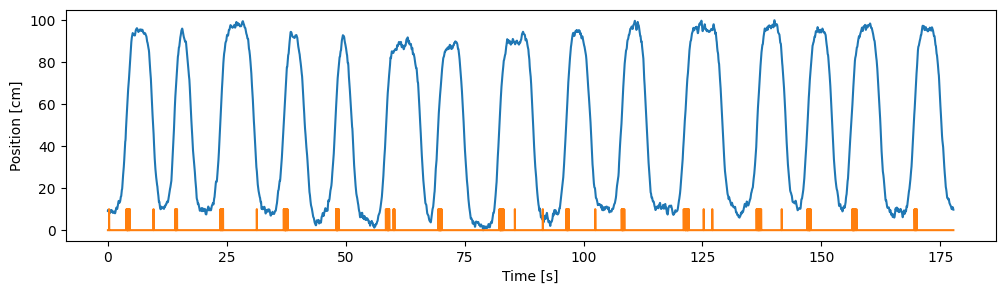

In [21]:
plot(t, X)               # Plot the position,
plot(t, 10 * spiketrain) # Plot the spikes,
xlabel('Time [s]')   # ... and label the axes.
ylabel('Position [cm]')
show()

**P:** ¿Existe una mejor manera de visualizar la actividad de picos y la posición?

**R:** Manteniendo la variable `spiketrain`, vamos a calcular una nueva variable, `spikeindex`, utilizando el comando `where()` de numpy:

```python
spikeindex=where(spiketrain!=0)[0]  # Determinar el índice de cada pico.
```

El vector `spikeindex` representa los índices en los que ocurren los picos. Podemos usar esto para indexar cualquiera de las variables cuyo tamaño coincida con el número de intervalos de tiempo en la grabación. Así que, otra visualización que podemos emplear ahora es graficar los tiempos y posiciones de los picos superpuestos sobre toda la trayectoria del movimiento. En Python:

Nota que al usar el término `'r.'` en la función de graficado, indicamos los tiempos y posiciones de los picmo puntos rojos.

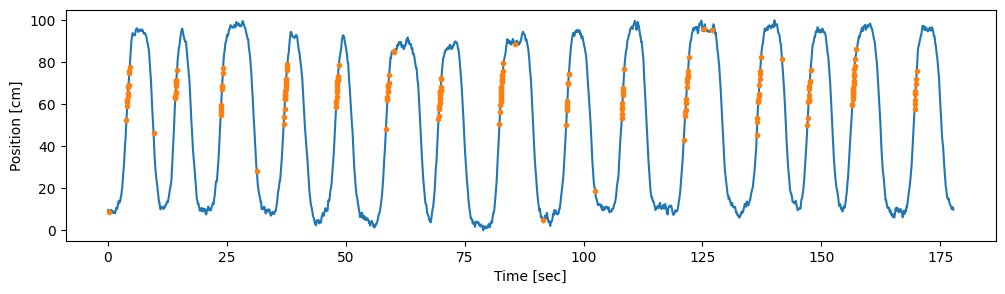

In [22]:
spikeindex = where(spiketrain!=0)[0]     # Get the spike indices.
plot(t, X)                               # Plot the position,
plot(t[spikeindex], X[spikeindex], '.')  # ... and the spikes.  
xlabel('Time [sec]')                     # Label the axes.
ylabel('Position [cm]')
show()

A partir de la figura anterior, está claro que la mayor parte de la actividad de picos ocurre cuando la rata está corriendo hacia arriba en la pista, en la dirección donde X está aumentando, en valores de X que van desde unos 50 cm hasta unos 80 cm. No vemos la misma actividad de picos en esta región cuando la rata está corriendo hacia abajo en la pista, en la dirección donde X está disminuyendo. Algunos picos ocurren en otras ubicaciones, pero estos parecen escasos en comparación con el disparo específico de lugar en esta región.

Otra forma de visualizar esta estructura de campo de lugar es construir un histograma normalizado por ocupación de la actividad de picos. Para hacerlo, definimos un conjunto de intervalos de posición que abarcan toda la pista de 100 cm, contamos el número de picos que ocurren en cada intervalo de ubicación, y dividimos por la ocupación, es decir, el tiempo total pasado en cada intervalo de ubicación. Dividir por la ocupación es importante. De lo contrario, las diferencias en la forma en que se presenta el estímulo pueden sesgar la caracterización de la relación respuesta-estímulo. Por ejemplo, si la rata pasara mucho más tiempo en la región de 50 a 80 cm, podríamos esperar más disparos en esa región, incluso si el disparo no dependiera en absoluto del lugar. Basándonos en nuestra visualización anterior, sabemos que este no es el caso para estos datos, pero es importante tener en cuenta cómo las estadísticas de una señal de estímulo podrían influir en las estadísticas de una señal de salida.

Vamos a calcular el histograma normalizado por ocupación en Python:

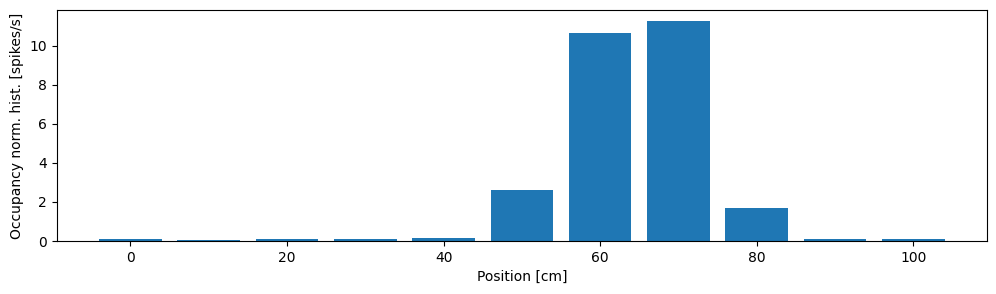

In [56]:
bin_edges = arange(-5, 106, 10)                              # Define spatial bins.
spikehist = histogram(X[spikeindex], bin_edges)[0]           # Histogram positions @ spikes.
occupancy = histogram(X, bin_edges)[0]*0.001                 # Convert occupancy to seconds.
bar(linspace(0, 100, 11), spikehist/occupancy, width=8)  # Plot results as bars.
xlabel('Position [cm]')                                      # Label the axes.
ylabel('Occupancy norm. hist. [spikes/s]')
show()

En la tercera línea de este código, multiplicamos la ocupación por 0.001 para poner la ocupación en unidades de segundos y el histograma normalizado por ocupación en unidades de picos por segundo. A partir del histograma normalizado por ocupación en la figura, vemos que la tasa de disparo es más alta alrededor de la posición de 60-70 cm y disminuye rápidamente a medida que la rata se aleja de esa ubicación. Esto corrobora los resultados de nuestras visualizaciones anteriores. Sin embargo, hay una característica de la actividad de picos que observamos previamente y que no estamos considerando en esta visualización. Aquí estamos relacionando los picos puramente con la posición, sin tener en cuenta la dirección del movimiento de la rata.

P: ¿Cómo podríamos construir una visualización que tenga en cuenta los picos como función tanto de la posición como de la dirección?

R: Una opción es construir histogramas normalizados por ocupación separados para el movimiento en cada dirección. Para hacerlo, necesitaríamos determinar, para cada intervalo de tiempo, si representa un período de movimiento donde la posición está aumentando o disminuyendo. ¿Cómo lo harías? (Lo haremos más adelante al construir modelos de campo de lugar.)

### Ajuste de un modelo de proceso puntual (Poisson GLM)

Cualquier modelo estadístico que describa datos que ocurren en puntos localizados en el tiempo, como los tiempos de disparo de neuronas, se denomina modelo de proceso puntual temporal. En el cuaderno 8, construimos un modelo de proceso puntual que describía la distribución de probabilidad de los tiempos de espera entre los disparos para una neurona sin un estímulo de conducción explícito. Aquí, de manera similar, nos gustaría construir un modelo estadístico, pero en este caso, el modelo debería caracterizar cómo la distribución de los datos depende de las covariables de interés: la posición del ratón y la dirección del movimiento.

**P:** ¿Te resultan familiares las nociones de modelo de proceso puntual, modelo de Poisson y parámetro de tasa?

**R:** Si no es así, considera revisar el estudio de caso en el cuaderno 8.

Un enfoque que utilizamos para modelar los datos de disparo en el cuaderno 8 fue un modelo de Poisson, en el que usamos un parámetro de tasa, $\lambda$, para definir la tasa esperada de disparos en cualquier intervalo de tiempo. Luego, calculamos el valor de $\lambda$ que maximiza la probabilidad de observar la actividad de disparo registrada. Para los datos de interés aquí, ampliamos este concepto definiendo una tasa que varía en el tiempo como una función de un conjunto de covariables. Estas covariables son cualquier variable cuya influencia sobre la actividad de disparo deseemos explorar. Nuestras visualizaciones sugieren que las covariables útiles para nuestro modelo incluyen la posición del ratón y su dirección de movimiento.

Definamos algunos términos. Dejemos que $X(t)$ represente la posición del ratón en el tiempo $t$, y que $D(t)$ represente la dirección del movimiento; establecemos $D(t) = -1$ cuando $X(t)$ está disminuyendo o el ratón está detenido, y $D(t) = +1$ cuando $X(t)$ está aumentando. Dado que estas señales de posición y dirección cambian en función del tiempo, también lo hace la tasa de disparo. Escribimos $\lambda(t) = f(X(t), D(t))$, donde $\lambda(t)$ se llama la función de tasa de Poisson, y $f$ es una función que necesitamos para definir el modelo.

¿Qué función deberíamos usar para $f(X(t), D(t))$? Queremos algo que capture la relación entre las covariables y los disparos, y que sea fácil de interpretar. El proceso de encontrar un modelo o conjunto de modelos que sean más consistentes con los datos se llama identificación de modelos o selección de modelos. Típicamente, este es un proceso iterativo en el que proponemos una clase de modelos, encontramos el modelo particular en esa clase que mejor se ajusta a los datos, evaluamos la calidad de ese modelo y decidimos si refinar el modelo aún más o sacar conclusiones del ajuste del modelo. En la práctica, es una buena idea comenzar con estadísticas descriptivas y visualizaciones de la relación entre las covariables y los datos de disparo para seleccionar una clase de modelos de proceso puntual. Para los datos de tren de disparo de interés aquí, nuestras visualizaciones sugieren un modelo donde la dependencia del disparo en la posición tiene una forma de montículo (como en el histograma normalizado por ocupación) e incorpora la dirección. Comenzamos con un modelo demasiado simple para fines pedagógicos.

El siguiente es un modelo muy básico inspirado en la regresión lineal simple:

$
\lambda(t) = \beta_0 + \beta_1 X(t)
$

La idea de la regresión lineal es expresar una variable de respuesta en el tiempo $t$ en términos de variables predictoras, o covariables. Aquí, $\beta_0$ y $\beta_1$ son parámetros desconocidos utilizados para caracterizar una dependencia lineal entre la variable de respuesta $\lambda(t)$ y la covariable $X(t)$. $\beta_0$ representa la tasa de disparo esperada en $X(t) = 0$, y $\beta_1$ representa el cambio en la tasa de disparo por cada unidad de aumento en la posición. Este modelo inicial no incluye ninguna dependencia en la dirección de movimiento del ratón (es decir, no hay término $D(t)$).

La forma del modelo se parece a una regresión lineal estándar, lo cual es reconfortante porque existen métodos en Python para resolver este tipo de problemas. Sin embargo, los datos observados son eventos de disparo; en tiempo discreto, los datos son conteos de disparos. Una regresión lineal estándar asume que la distribución de los datos, dadas las covariables, es normal. Los conteos de disparos solo pueden tomar valores enteros no negativos, por lo que su distribución no puede ser normal. Cuando el número de conteos de disparos en cada intervalo de tiempo es muy grande, es posible que la distribución de los datos pueda aproximarse por una distribución normal, y en este caso, los métodos de regresión simple podrían funcionar. Pero para los datos de disparo de interés aquí, tenemos muy pocos disparos (0 o 1) en cada intervalo de tiempo de 1 ms, por lo que un ajuste de regresión simple no sería correcto.

En su lugar, debemos ajustar un modelo de regresión de Poisson a los datos. Si dejamos que $Y_i$ sea el número de disparos observados en el intervalo $i$, entonces bajo el modelo de regresión de Poisson, $Y_i$ tiene una distribución de Poisson con un parámetro de media igual a la variable de respuesta $\lambda(t)$ integrada sobre el intervalo $i$.

¿Cómo ajustamos el modelo de regresión de Poisson? Resulta que los modelos de regresión de Poisson de cierta forma se pueden ajustar de manera eficiente utilizando la teoría de modelos lineales generalizados (GLM). En Python, podemos ajustar este modelo utilizando el paquete `statsmodels`. Antes de aplicar esta función directamente a los datos, obtengamos una visión general de las entradas y salidas de la función. En Python, consideramos el modelo GLM del paquete `statsmodels`. Construiremos un modelo usando:

```python
GLM(Y, X_1, family(link()))
```

La primera entrada, $Y$, es un vector de los conteos de disparos en cada paso de tiempo. En este caso, $Y$ es el vector `spiketrain` que calculamos anteriormente. La segunda entrada, $X_1$, es una matriz de las covariables de las que depende el disparo. El tamaño de esta matriz es $n \times p$, donde $p$ es el número de covariables en el modelo, y $n$ es el número de observaciones. Dado que nuestro modelo está dado por $\lambda(t) = \beta_0 + \beta_1 X(t)$, añadiremos una columna de unos a la matriz de datos $X$, para que podamos ajustar la intersección $\beta_0$ a nuestros datos. Por lo tanto, $X_1$ es una matriz $n \times 2$, donde $n$ es el número de puntos de datos (177,761) que representan la posición del ratón a lo largo de la pista. La tercera entrada indica la distribución de los datos de conteo de disparos en $Y$. Para un modelo de regresión de Poisson de datos de conteo de disparos, utilizamos la familia de Poisson. De hecho, para la mayoría de los modelos de conteo de disparos neuronales ajustados utilizando GLM, incluso aquellos que no son procesos de Poisson, utilizamos la distribución de Poisson. La entrada `family` se caracteriza por una función de enlace entre la tasa de disparo y las covariables. Específicamente, si queremos ajustar un modelo de la forma $\lambda(t) = \exp(\beta_0 + \beta_1 X(t))$, entonces diríamos que la función $\log(\lambda(t)) = \beta_0 + \beta_1 X(t)$ es la función de enlace. Para el Modelo 1, esta es simplemente la función identidad. A continuación, mostramos una mejor manera de seleccionar esta función de enlace.

El atributo `params` de la función `fit` es un vector de números que representa las estimaciones de máxima verosimilitud de los parámetros del modelo, que para este ejemplo hemos etiquetado como $\beta_0$ y $\beta_1$. Usamos la notación con "sombrero" (hat) sobre un parámetro para representar su estimación. La estimación de máxima verosimilitud de $\beta_0$ se escribe como $\hat{\beta}_0$, y la estimación de máxima verosimilitud de $\beta_1$ se escribe como $\hat{\beta}_1$. Ahora, usemos esta función para ajustar los parámetros del Modelo 1 a los datos observados de ubicación y disparos.


In [58]:
# Create a dataframe of predictors that includes X and a constant term
predictors = df(data={'Intercept': ones_like(X), 'X': X})

# GLM model with Poisson family and identity link function
model1 = sm.GLM(spiketrain, predictors, family=Poisson(identity()))
model1_results = model1.fit() # Fit model to our data
b1 = model1_results.params
print('b1:')
print(b1)

C:\Users\edier\miniconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


b1:
Intercept   -0.000097
X            0.000027
dtype: float64


**Q:** What do you notice about the values of the model fit ($\beta_1$)? Do the results make sense?

**A:** Initially, you may notice that Python outputs a warning at the command line that this model—particularly the identity link function—may be inappropriate. Let’s ignore this warning and attempt to interpret the resulting parameter estimates. The first of these values is the maximum likelihood estimate for $\beta_0$. If we believed this model was accurate, we could interpret this parameter as indicating that the expected firing rate at position $X(t) = 0$ is $-0.097$ spikes per millisecond, or about $-0.097$ spikes per second, and that as the rat moves in the positive direction, the firing rate increases by $\beta_1$ spikes per second for every centimeter the rat moves. 

This result should immediately raise some red flags. The fact that the firing rate is negative indicates that the model becomes uninterpretable for observed values of $X(t)$. This suggests one major problem with Model 1—the firing rate is negative—and motivates changes to the model's link function. To further visualize the quality of this model, we can compare the dependence it defines between position and spike rate to the occupancy normalized histogram we computed earlier. In this case, we use the positions defined by the histogram bins and compute the modeled spike rate at these points.

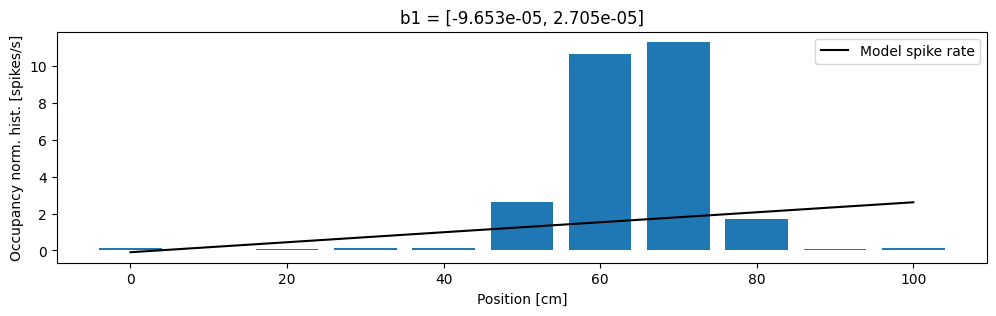

In [25]:
bins = linspace(0, 100, 11)
bar(bins, spikehist/occupancy, width=8)    # Plot results as bars.
plot(bins,(b1[0]+b1[1]*bins)*1000, 'k',
     label="Model spike rate")             # Plot model.
xlabel('Position [cm]')                    # Label the axes.
ylabel('Occupancy norm. hist. [spikes/s]')
title("b1 = [{0[0]:.4}, {0[1]:.4}]".format(b1))
legend()
show()

Vemos que la tasa de disparo del modelo captura algunas características del disparo observado, por ejemplo, el hecho de que la tasa de disparo aumenta a medida que la rata se mueve desde la posición $x = 0$ hacia la posición $x = 60$. Pero el modelo no capta gran parte de la estructura, por ejemplo, el hecho de que la tasa de disparo no cambia linealmente con la posición y comienza a disminuir cuando la posición de la rata supera los $x = 70$. Esto sugiere un segundo problema con este modelo: la forma de la relación entre la posición y la tasa de disparo es incorrecta.

### Refinando el Modelo

Concluimos que nuestra propuesta inicial, el Modelo 1, no representa bien los datos. Por lo tanto, refinemos el modelo para abordar los problemas identificados. Primero, elijamos una función de enlace que sea más apropiada para el modelado de procesos puntuales. Nos gustaría una función que asegure que la función de tasa sea no negativa y que sea fácil de ajustar. La teoría del modelado lineal generalizado sugiere una función en particular: el enlace logarítmico. Establecemos que el logaritmo de la tasa de disparo sea una función lineal de las covariables. Si mantenemos la posición como la única covariable, esto conduce a un modelo de la forma:

$$
\log(\lambda(t)) = \beta_0 + \beta_1 X(t)
$$

o, de manera equivalente,

$$
\lambda(t) = \exp(\beta_0 + \beta_1 X(t))
$$

Esta función de enlace se llama el enlace canónico para datos de Poisson. Tiene una serie de propiedades atractivas. Como se deseaba, asegura que la función de tasa sea positiva.

**P:** Considera la expresión para $\lambda(t)$ arriba. ¿Por qué $\lambda(t)$ debe ser siempre positiva?

La elección de un enlace logarítmico también asegura que la verosimilitud de los datos sea cóncava con respecto a los parámetros del modelo. Esto significa que la verosimilitud solo tiene un valor máximo local, que es la estimación de máxima verosimilitud (ML). También se puede demostrar que, en muchos casos, los estimadores de los parámetros serán asintóticamente normales, lo que nos permitirá construir intervalos de confianza y hacer declaraciones de significancia sobre ellos \[Kass, Eden & Brown, 2014\].

Para ajustar el Modelo 2 en Python, usamos el mismo modelo que antes pero reemplazamos la función de enlace con $\log$:

In [26]:
model2 = sm.GLM(spiketrain, predictors, family=Poisson(log())) # GLM model with Poisson family and log link function
model2_results = model2.fit() # Fit model to our data
b2 = model2_results.params    # Get the predicted coefficient vector

C:\Users\edier\miniconda3\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


De hecho, si omitimos el nombre de la función de enlace en la rutina `sm.GLM`, esta usará automáticamente el enlace canónico para la distribución seleccionada. Dado que el enlace logarítmico es canónico para datos de Poisson, simplemente podemos ejecutar los comandos:

In [27]:
model2 = sm.GLM(spiketrain, predictors, family=Poisson())  # GLM model with Poisson family, omitting link function
model2_results = model2.fit()  # Fit model to our data
b2 = model2_results.params     # Get the predicted coefficient vector
print(b2)

Intercept   -7.438887
X            0.012943
dtype: float64


**P:** Ejecuta la función `fit` con el enlace logarítmico en Python. ¿Qué encuentras?

**R:** Esta vez, encontramos que Python no emite una advertencia sobre la posible inapropiedad de la función de enlace. La inspección de los valores estimados de los parámetros revela $b_2 = [-7.43888719, 0.01294342]$. Estos valores son marcadamente diferentes de los valores de parámetros $b_1$ encontrados usando el Modelo 1. La razón de esta diferencia es que la forma del modelo tiene un impacto importante en la interpretación de los valores de los parámetros. A continuación, discutimos la interpretación de estos valores de los parámetros en detalle.

Examinemos el ajuste del modelo más de cerca. Cuando $x = 0$, la tasa de disparo bajo el Modelo 2 es

\begin{align}
\lambda(t) &= \exp(\beta_0 + \beta_1 \times 0) \\
           &= \exp(\beta_0) \\
           &= 0.0006\text{ spikes/ms} \\
           &= 0.6 \text{ spikes/s}
\end{align}

donde hemos utilizado el valor $b_2[0]$. Si el ratón se mueve de la posición $x = 0$ a $x = 1$, la tasa de disparo se convierte en

\begin{align}\lambda(t) &= \exp(\beta_0 + \beta_1 × 1) \\
  &= \exp(\beta_0 + \beta_1)\\
  &= \exp(\beta_0)\exp(\beta_1)\\
  &= 1.013 \exp(\beta_0),\end{align}

donde hemos utilizado el valor $b_2[1]$. Es decir, un aumento de 1 cm en la posición incrementa la tasa de disparo en un 1.3%. Debido a la función de enlace, la posición ahora tiene un efecto multiplicativo en lugar de aditivo sobre la tasa de disparo. En lugar de sumar a la tasa de disparo, cada aumento de posición conduce a una modulación multiplicativa de la tasa de disparo, con un incremento de aproximadamente un 1% por cm. Veamos cómo se ve este modelo comparándolo con el histograma normalizado por ocupación de los datos. En Python,


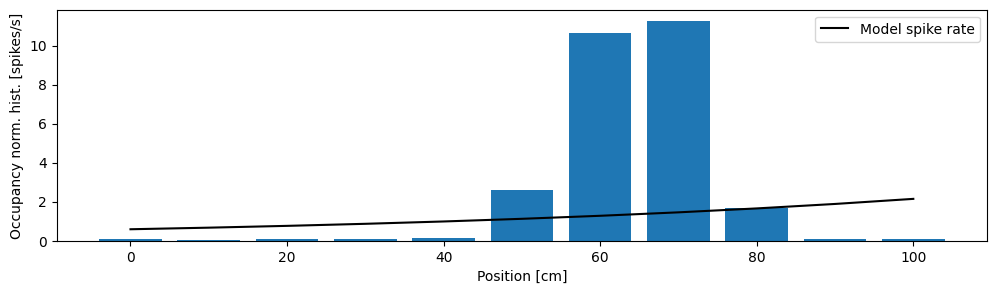

In [28]:
bar(bins, spikehist/occupancy, width=8)    # Plot results as bars.
plot(bins, exp(b2[0] + b2[1] * bins) * 1000, 'k',
     label='Model spike rate')             # Plot model.
xlabel('Position [cm]')                    # Label the axes.
ylabel('Occupancy norm. hist. [spikes/s]')
legend()
show()

**P:** Considera el Modelo 2 y los datos (la figura arriba). ¿Cómo se comparan los dos?

**R:** La inspección visual sugiere que hemos resuelto un problema: la tasa de disparo ya no es negativa en ningún lugar. Sin embargo, el ajuste del modelo aún no concuerda con la estructura observada en el histograma normalizado por ocupación. Hemos mejorado la función de enlace, pero usar solo la posición como covariable lleva a una tasa que es una función exponencial de la posición del ratón.

Hay muchas variables que podríamos considerar agregar a este modelo, pero ¿qué variables podríamos añadir para capturar mejor la dependencia entre la tasa de disparo y la posición, en particular? Una idea podría ser incluir términos no lineales, como el cuadrado del valor de la posición. Esto nos da un tercer modelo candidato:

$$
\lambda(t) = \exp(\beta_0 + \beta_1 \times \text{posición} + \beta_2 \times \text{posición}^2)
$$

Comparado con el Modelo 2, ahora hemos incluido un término adicional $\text{posición}^2$ y un coeficiente desconocido $\beta_2$.

**P:** Dijimos anteriormente que usaríamos modelos lineales generalizados. ¿Viola el uso del término no lineal $\text{posición}^2$ esto?

**R:** Puede ser mejor pensar en "lineal" en "modelos lineales generalizados" como que requiere que alguna función de la media de la variable de respuesta sea una función lineal de los coeficientes (es decir, los $\beta$). Las covariables pueden ser funciones lineales o no lineales de las cantidades observadas (por ejemplo, el cuadrado de la posición, el seno del ángulo de dirección de la cabeza, etc.)

Para ajustar el Modelo 3 en Python, agregamos otra columna a la matriz de covariables, el segundo argumento del modelo GLM.


In [29]:
# Fit Model 3 to the spike train data (omitting last input).
predictors['X2'] = X**2       # Add column for X^2

# GLM model with Poisson family and identity link function
model3 = sm.GLM(spiketrain, predictors, family=Poisson())
model3_results = model3.fit() # Fit model to our data
b3 = model3_results.params    # Get the predicted coefficient vector
print('b3:\n', b3)

b3:
 Intercept   -26.279057
X             0.690114
X2           -0.005463
dtype: float64


**P:** Compara los predictores en el GLM para el Modelo 3 versus el Modelo 2. ¿En qué se parecen los dos predictores? ¿En qué se diferencian?

**P:** Ejecuta la función de ajuste con el enlace logarítmico en Python. ¿Qué encuentras?

**R:** Al igual que con el Modelo 2, encontramos que Python no produce advertencias de que la función de enlace pueda ser inapropiada. En este caso, hay tres valores de parámetros estimados en $\mathbf{b}_3$.

Ahora, interpretemos las estimaciones de los parámetros para el Modelo 3. La estimación del primer parámetro es $\beta_0=-26.3$. Esto significa que cuando el ratón está en la posición $x = 0$, la tasa de disparo es $\lamda = \exp(\beta_0)=-26.3=0$. Hay casi ninguna posibilidad de observar un disparo cuando el ratón está en esta ubicación. ¿Qué sucede cuando el ratón se mueve en la dirección positiva? Esto está determinado tanto por $\beta_1=0.6901$ como por $\beta_2=-0.0055$. Por cada incremento unitario en la posición, la tasa de disparo se multiplica por $\exp(\beta_1)=1.99$, pero al mismo tiempo, por cada incremento unitario en el cuadrado de la posición, la tasa de disparo se multiplica por $\exp(\beta_2)=0.99$.

Expresado de esta manera, los valores de los parámetros $\beta_1$ y $\beta_2$ parecen difíciles de interpretar. Una vez que visualizamos este modelo, nos damos cuenta de que hay otra forma de expresar el modelo para que los parámetros sean más fáciles de interpretar:


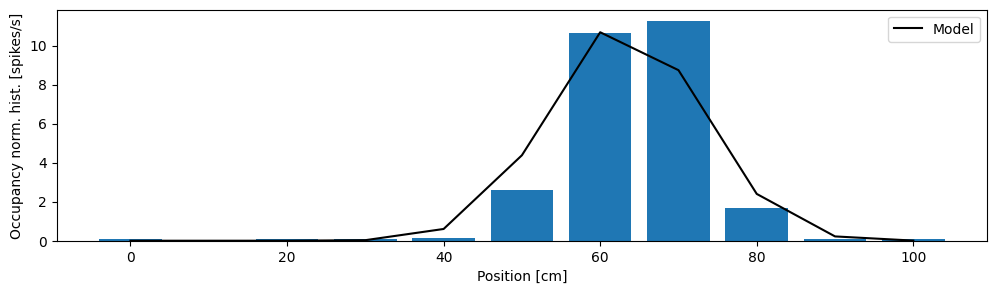

In [30]:
bar(bins, spikehist / occupancy, width=8)    # Plot results as bars.
plot(bins, exp(b3[0] + b3[1] * bins + b3[2] * bins**2) * 1000,  # Plot model.
     'k', label='Model')   
xlabel('Position [cm]')                      # Label the axes.
ylabel('Occupancy norm. hist. [spikes/s]')
legend()
show()

Vemos en la figura anterior que el Modelo 3 se alinea mucho más con el histograma normalizado por ocupación. La tasa de disparo es pequeña al comienzo de la pista, aumenta hasta una tasa de disparo máxima de cerca de 10 Hz a unos 60 cm a lo largo de la pista, y luego disminuye a medida que la posición sigue aumentando. La tasa de disparo modelada como función de la posición se asemeja a la densidad en forma de campana o montículo que a menudo asociamos con la distribución Gaussiana (o normal). El hecho de que la tasa de disparo sea la exponencial de una función cuadrática de la posición significa que podemos reescribir el modelo en una forma que se asemeje más a la función Gaussiana:

$$
\lambda(t) = \lambda_{\text{max}} \exp\left(-\frac{(x - x_{\text{ctr}})^2}{2\sigma^2}\right)
$$

donde $\mu=-\beta_1/(2\beta_2)$ es el punto a lo largo de la pista donde la tasa de disparo es máxima (el centro del campo de lugar), $\sigma=-1/(2\beta_2)$ determina el rango sobre el cual la tasa de disparo está elevada (el tamaño del campo de lugar), y $\sigma=exp(\beta_0 - \beta_1^2 / (4\beta_2)$ es la tasa de disparo máxima en el centro del campo de lugar.

En este ejemplo, podemos utilizar los coeficientes estimados del GLM para estimar estos nuevos parámetros del modelo relacionados con el centro, tamaño y tasa de disparo máxima del campo de lugar. El método de ajuste nos ha dado las estimaciones de máxima verosimilitud para $\beta_0$, $\beta_1$, y $\beta_2$. Un resultado importante de la teoría estadística es que la estimación de máxima verosimilitud de cualquier función de los parámetros del modelo es simplemente esa misma función aplicada a las estimaciones de máxima verosimilitud de los parámetros. Esto se conoce comúnmente como invarianza o equivarianza [Kass, Eden & Brown, 2014]. Así que $\mu=-\beta_1/(2\beta_2)$ es la estimación de máxima verosimilitud del centro del campo de lugar, $\sigma$ es la estimación de máxima verosimilitud del tamaño del campo de lugar, y así sucesivamente.

Ahora, usemos estas expresiones para calcular las estimaciones de máxima verosimilitud en Python:

In [31]:
#Compute maximum likelihood estimates of
mu = -b3[1] / (2 * b3[2])                  # place field center
sigma = sqrt(-1 / (2 * b3[2]))             # place field size
alpha = exp(b3[0] - b3[1]**2 / 4 / b3[2])  # max firing rate

print('mu: {}\nsigma: {}\nalpha: {}'.format(mu, sigma, alpha))

mu: 63.16295780404714
sigma: 9.56689084187336
alpha: 0.011285495199178156



**Pregunta**: ¿Cuáles son las unidades de cada una de estas estimaciones de parámetros?

**Respuesta**: Las unidades de $\mu$ y $\sigma$ son centímetros, las mismas que las unidades de $X$. Las unidades de $\alpha$, la tasa máxima de disparo, son spikes por intervalo de tiempo del vector spiketrain. Dado que cada intervalo de tiempo es de 1 ms, las unidades son spikes/ms. Entonces, un valor de $\alpha$ spikes/ms es equivalente a una tasa máxima de disparo de $\alpha \times 1000$ spikes/s.

Vemos que el centro estimado del campo de lugar está aproximadamente a 63.2 cm a lo largo de la pista. El tamaño estimado del campo de lugar, $\sigma=9.6$, sugiere que la tasa de disparo disminuye aproximadamente un 40% cuando la rata está a unos 9.6 cm del centro del campo de lugar, y disminuye aproximadamente un 85% cuando la rata está a unos 19 cm del centro del campo de lugar. La neurona dispara a una tasa cercana a $\alpha=11$ spikes/s cuando la rata está a 63 cm a lo largo de la pista, pero a menos de 2 spikes/s cuando la rata está a más de 19 cm de esa posición.


### Comparación y evaluación de modelos

Hemos ajustado varios modelos para el campo receptivo de esta neurona y los hemos comparado a través de inspección visual. Idealmente, nos gustaría ir más allá de las comparaciones cualitativas y considerar herramientas cuantitativas que nos ayuden a evaluar y comparar diferentes modelos. Para los modelos estadísticos, a menudo usamos el término "bondad de ajuste" para describir qué tan bien un modelo captura la estructura en los datos observados y qué tan bien predice datos futuros. No existe un procedimiento único para medir la bondad de ajuste; en cambio, hay muchas herramientas que, en conjunto, pueden proporcionar una perspectiva amplia sobre las fortalezas y debilidades de un conjunto de modelos. Exploramos algunos enfoques para comparar la bondad de ajuste relativa entre dos modelos y luego métodos para evaluar la bondad de ajuste general de un solo modelo.

#### Método 1: Comparación de valores AIC

Supongamos que queremos comparar la calidad del ajuste a los datos de los Modelos 2 y 3. ¿Qué medida podríamos usar para comparar estos modelos? Un pensamiento natural es usar la verosimilitud. Ya hemos utilizado la verosimilitud para seleccionar los valores de los parámetros de cada uno de estos modelos; seleccionamos los parámetros que maximizaron la verosimilitud de los datos. Podemos pensar en la selección de los parámetros del modelo como la selección entre un conjunto de modelos con la misma forma de modelo pero diferentes valores de parámetros. En ese caso, la verosimilitud fue la medida que utilizamos para hacer la selección.

Sin embargo, hay un problema importante al usar solo la verosimilitud para comparar la bondad de ajuste entre diferentes clases de modelos. Resulta que a medida que agregamos parámetros al modelo y lo hacemos más complejo, tendemos a aumentar la verosimilitud de los datos, ya sea que esos términos adicionales describan con precisión los procesos que generan los datos o no. Si seleccionáramos modelos que maximizan la verosimilitud de los datos sin considerar el tamaño del modelo, tenderíamos a obtener modelos muy grandes que se ajustan bien a los datos observados pero que no predicen o describen bien los datos futuros. Esto se conoce como el problema del sobreajuste. Para evitar el sobreajuste, nos vemos obligados a equilibrar la capacidad de ajustar conjuntos de datos complicados con el deseo de utilizar modelos simples con un pequeño número de parámetros. Este compromiso a veces se denomina el objetivo de la parsimonia en la modelización. Queremos ser cuidadosos con el número de parámetros que permitimos que tenga un modelo. Llamamos modelo parsimonioso a un modelo que describe bien los datos con el menor número posible de parámetros.

Un enfoque común para prevenir el sobreajuste es la validación cruzada. Existen múltiples tipos de validación cruzada, pero todos comparten una idea común: dividir los datos en varias porciones, ajustar el modelo en una porción de los datos (llamada conjunto de entrenamiento) y determinar qué tan bien describe el ajuste resultante una porción separada de los datos (llamada conjunto de prueba). Esto asegura que el modelo seleccionado sea uno que pueda generalizar a conjuntos de datos adicionales que no se utilizaron para ajustar el modelo. Un desafío con la validación cruzada es que puede ser computacionalmente costosa. Por ejemplo, uno de los enfoques de validación cruzada más robustos, llamado validación cruzada completa con eliminación de uno, implica omitir secuencialmente cada punto de datos, ajustar un modelo a los datos restantes y evaluar qué tan bien el modelo ajustado predice el punto de datos excluido. Esto implica ajustar $N$ modelos, donde $N$ es el número de puntos de datos observados.

Aquí, en lugar de ajustar un gran número de modelos, tomamos otro enfoque, que da resultados equivalentes a la validación cruzada cuando el conjunto de datos es grande. Es decir, utilizamos medidas de verosimilitud penalizada para comparar tipos de modelos. Estas medidas hacen explícito el compromiso entre ajustar bien los datos (aumentando la verosimilitud) y utilizar un pequeño número de parámetros (penalizando los modelos grandes). Consideremos una de estas medidas, el criterio de información de Akaike (AIC). Se define como:

$$ \text{AIC} = - 2\log{L(\theta_{ML}})+2p $$

donde $\hat{L}$ es la verosimilitud de los datos para la estimación de máxima verosimilitud seleccionada $\hat{\theta}$, y $k$ es el número de parámetros en el modelo. Consideramos el $2k$ en la expresión como una penalización para modelos con un gran número de parámetros.

Al comparar modelos, calculamos el AIC para cada modelo por separado y luego calculamos la diferencia en AICs entre modelos. Para los modelos que describen con precisión la estructura de los datos, $\hat{L}$ será alta, y por lo tanto $-2\log(\hat{L})$ será pequeño. Los modelos parsimoniosos tendrán un pequeño número de parámetros, y por lo tanto $2k$ será pequeño. Por lo tanto, estamos buscando modelos con valores de AIC lo más pequeños posible.

¿Cómo calculamos la verosimilitud o el logaritmo de la verosimilitud de los datos para los modelos en Python? Una forma es utilizar el hecho de que estamos modelando la secuencia de spikes como una variable aleatoria de Poisson en cada punto en el tiempo con parámetros de tasa determinados por el modelo. Para ver el AIC de un GLM en Python, simplemente podemos usar el atributo `aic` de los resultados del modelo: `model2_results.aic`. Sin embargo, el cálculo no es difícil. Para el Modelo 2, podemos calcular el AIC de la siguiente manera:


In [32]:
LL2 = model2.loglike(b2)
AIC2 = -2 * LL2 + 2 * 2
print('AIC2: ', AIC2)
print('model2_results.aic: ', model2_results.aic)

AIC2:  3344.7908629386075
model2_results.aic:  3344.7908629386075



La primera línea de este código calcula la log-verosimilitud para el Modelo 2. Recordemos que la verosimilitud es la distribución conjunta de todos los datos para un modelo específico. En este caso, el número de spikes en cada intervalo se modela como una variable aleatoria de Poisson con tasa $\lambda(t)$. Por lo tanto, la log-verosimilitud ($\text{LL}_2$) es el logaritmo del producto de los valores de probabilidad de Poisson para los spikes observados bajo el modelo propuesto (o equivalentemente, la suma del logaritmo de estos valores de probabilidad de Poisson). La segunda línea calcula el AIC para este modelo. Observa que usamos un valor de $p = 2$, ya que hay dos parámetros en este modelo ($\beta_0$ y $\beta_1$). Por último, mostramos que, efectivamente, esto es lo mismo que resulta al acceder al atributo `aic` de los resultados del modelo.

De manera similar, podemos calcular el AIC para el Modelo 3:

In [33]:
LL3 = model3.loglike(b3)
AIC3 = -2 * LL3 + 2 * 3
print('AIC3: ', AIC3)

AIC3:  2708.776362292046


**Q**: Considera la definición de $AIC_3$. ¿Puedes explicar en palabras los diferentes términos? ¿Qué representa el término $2*3$? ¿Cuántos parámetros hay en el Modelo 3?

Finalmente, podemos calcular la diferencia entre los valores de AIC para estos dos modelos:

In [35]:
dAIC = AIC2 - AIC3
print('dAIC: ', dAIC)

dAIC:  636.0145006465614


Encontramos un valor de $dAIC = 636.0145$. Esta diferencia indica que el AIC del Modelo 3 es menor que el del Modelo 2, lo que sugiere que el Modelo 3 es superior. ¿Cómo deberíamos interpretar el valor de esta diferencia? La respuesta depende del modelo probabilístico que estemos utilizando, y generalmente solo nos interesa cuál modelo tiene el AIC más bajo sin preocuparnos por la magnitud de la diferencia. Sin embargo, una forma aproximada de pensar en este valor es en términos de la penalización. El hecho de que el Modelo 3 tenga un AIC de aproximadamente 636 menos que el AIC del Modelo 2 sugiere que el Modelo 3 seguiría siendo preferible al Modelo 2 incluso si el Modelo 3 tuviera 636/2 = 318 parámetros más de los que tiene actualmente.

Resulta que hay una forma más sencilla de calcular la diferencia en los AIC entre dos GLMs. Cada vez que Python (y la mayoría de los otros paquetes de software computacional) calcula la solución de máxima verosimilitud para un GLM, también calcula la devianza del modelo. La devianza del modelo es una medida de la falta de ajuste entre el modelo y los datos, que se define por

$$
\text{Deviance} = -2 \text{Log}L(\theta_{ML}) + C)
$$

donde $C$ es una constante. Por lo tanto, la diferencia en los valores de AIC entre dos modelos se puede calcular como

$$
\Delta AIC = \text{AIC}_1 - \text{AIC}_2 =Dev_1 + 2p_1-Dev=2+2p_2
$$

donde $AIC_1$, $Dev_1$ y $p_1$ son el AIC, devianza y número de parámetros para el primer modelo, y $AIC_2$, $Dev_2$ y $p_2$ son el AIC, devianza y número de parámetros para el segundo modelo. La constante $C$ se cancela al calcular la diferencia en los valores de AIC.

En Python, podemos calcular los valores para la devianza y la diferencia en AIC de la siguiente manera:

In [36]:
dev2 = model2_results.deviance # Deviance from model 2
dev3 = model3_results.deviance # Deviance from model 3
dAIC = (dev2 + 2*2) - (dev3 + 2*3)
print('dAIC: ', dAIC)
print('Another method: ', model2_results.aic - model3_results.aic)

dAIC:  636.0145006465605
Another method:  636.0145006465614


La diferencia resultante en los AICs (variable $dAIC$) coincide con el valor que calculamos anteriormente.

**Método 2: Prueba de Chi-Cuadrado para Modelos Anidados.**  
El AIC proporciona un método para identificar modelos parsimoniosos y comparar entre modelos, pero por sí solo no indica si un modelo en particular proporciona una mejora estadísticamente significativa en su descripción de un conjunto de datos. Por ejemplo, podríamos agregar un predictor a un modelo que no tiene ninguna relación real con los datos observados y, sin embargo, disminuir el AIC por casualidad. Para evaluar si un modelo proporciona una mejora significativa sobre otro, podemos usar pruebas de hipótesis basadas en las verosimilitudes de los modelos.

En particular, existe una clase general de pruebas de hipótesis llamadas pruebas de razón de verosimilitud máxima (MLRTs) que a menudo proporcionan la comparación estadística más poderosa entre modelos. En general, puede ser difícil calcular la estadística de prueba y su distribución muestral para las MLRTs. Sin embargo, se vuelve fácil realizar esta prueba en casos donde estamos comparando dos GLMs anidados, es decir, cuando uno de los modelos puede hacerse equivalente al otro al fijar algunos parámetros en valores específicos. Por ejemplo, es posible hacer que el Modelo 3 sea equivalente al Modelo 2 fijando $\beta_2 = 0$. Decimos que el Modelo 2 está anidado en el Modelo 3. Sin embargo, no hay forma de fijar parámetros para hacer que el Modelo 2 sea equivalente al Modelo 1 o viceversa, por lo que estos modelos no están anidados. Se puede demostrar que cuando comparamos dos GLMs de Poisson anidados para datos de trenes de espigas, la MLRT será asintóticamente una simple prueba de chi-cuadrado ($\chi^2$). La demostración de este resultado se puede encontrar en muchos libros de texto sobre GLMs, como *McCullagh & Nelder, 1989*.

Especifiquemos los componentes de esta prueba de hipótesis. Supongamos que el modelo anidado tiene $n_1$ parámetros $\theta_{n1}$, y que el modelo más grande tiene $n_2$ parámetros, $\beta_{n2}$. La hipótesis nula para esta prueba es $H_0: \beta_{n1+1}=...=\beta{n2}= 0$, que todos los parámetros adicionales no contenidos en el modelo anidado son iguales a cero. La hipótesis alternativa es que al menos uno de estos parámetros adicionales es diferente de cero. La estadística de prueba para esta MLRT es equivalente a la diferencia en las desviaciones entre el modelo anidado (aquí, $\text{Deviance}_1$) y el modelo más grande (aquí, $\text{Dev}_2$),

$$
\chi^2 = \text{Deviance}_1 - \text{Deviance}_2
$$

Bajo la hipótesis nula, esta estadística debería tener asintóticamente una distribución chi-cuadrado con $n_2-n_1$ grados de libertad. Podemos calcular el valor p para una prueba que compare dos GLMs anidados para datos de trenes de espigas utilizando el objeto `chi2` en el módulo `scipy.stats` de Python.

Vamos a calcular el valor p para una MLRT que compare los Modelos 2 y 3:

In [37]:
p = 1 - chi2.cdf(dev2 - dev3, 1) # Compare Models 2 and 3, nested GLMs.
print('p:', p)

p: 0.0


En este caso, la diferencia en los parámetros entre el Modelo 2 y el Modelo 3 es 1; el Modelo 3 tiene un parámetro adicional. Por lo tanto, establecemos los grados de libertad de la distribución chi-cuadrado en 1, el segundo argumento de la función `chi2.cdf()`. Encontramos que el valor p calculado es cero, con la precisión que Python es capaz de calcular la distribución chi-cuadrado. En la práctica, esto significa que el valor p para esta prueba no es exactamente cero, pero es menor que aproximadamente $2.2 \times 10^{-16}$ (ver [aquí](https://docs.python.org/3/tutorial/floatingpoint.html) para una discusión sobre la epsilon de la máquina en Python). Tenemos una gran cantidad de evidencia de que el parámetro cuadrático adicional en el Modelo 3, $\beta_2$, es distinto de cero.

**Método 3: Intervalos de Confianza para Parámetros Individuales del Modelo.**  
Si queremos probar directamente si un parámetro contribuye significativamente al modelo, podemos examinar su estimación de intervalo. El procedimiento de ajuste del GLM no solo calcula el estimador de máxima verosimilitud para cada parámetro del modelo, sino que también calcula la información de Fisher, una cantidad relacionada con la curvatura de la verosimilitud, que puede usarse para calcular intervalos de confianza sobre cualquier parámetro individual o cualquier combinación de parámetros. No discutimos la información de Fisher en detalle aquí (para más información, ver *Kass, Eden & Brown, 2014*), pero la idea básica es intuitiva. Si la verosimilitud es muy plana en su máximo, entonces cambiar ligeramente los valores de los parámetros no disminuirá sustancialmente la verosimilitud. Por lo tanto, existe un rango potencialmente amplio de valores de parámetros que podrían hacer que los datos sean probables. Si la verosimilitud es muy pronunciada en su máximo, entonces un ligero cambio en los valores de los parámetros causaría un gran cambio en la verosimilitud, y por lo tanto un rango mucho más estrecho de valores de parámetros sería consistente con los datos.

La clase `GLMResults` contiene una variedad de atributos útiles. Dos componentes que son útiles para examinar la significancia de los parámetros individuales del modelo son `bse` y `pvalues`. El primero, `bse`, proporciona el error estándar de cada estimación de parámetro. Dado que los estimadores de máxima verosimilitud tienen distribuciones aproximadamente normales con suficiente cantidad de datos, un intervalo de confianza aproximado del 95% para cualquier parámetro $\beta_j$ sería $\hat{\beta_j} \pm 1.96 \cdot SE(\hat{\beta_j})$, donde $\hat{\beta_j}$ es la estimación del parámetro y $SE(\hat{\beta_j})$ es el error estándar estimado.

Vamos ahora a usar el atributo `bse` para calcular intervalos de confianza para los parámetros del Modelo 2:

In [38]:
CI2 = array([b2 - 2 * model2_results.bse, b2 + 2 * model2_results.bse]) # Compute 95% CI for parameters of Model 2.
print('CI2:\n', CI2)

CI2:
 [[-7.73444907  0.00892032]
 [-7.14332531  0.01696651]]


La columna izquierda de la variable `CI2` es el intervalo de confianza para $\beta_0$, y la columna derecha es el intervalo de confianza para $\beta_1$. ¿Cómo deberíamos interpretar estos intervalos de confianza? Al igual que antes, serán más interpretables si los exponenciamos primero.

In [39]:
eCI2 = exp(CI2)
print(eCI2)

[[4.37493342e-04 1.00896023e+00]
 [7.90120328e-04 1.01711126e+00]]


El intervalo de confianza para $\beta_0$ describe la incertidumbre en la tasa de disparo en la posición $x = 0$. En esa posición, estamos al 95% seguros de que la tasa está entre 0.0004 y 0.0008 (la columna izquierda de `eCI2`) disparos por milisegundo, o entre 0.4 y 0.8 disparos por segundo. El intervalo de confianza para $\beta_1$ describe la incertidumbre en el efecto de un cambio unitario en la posición sobre la tasa de disparo. Cada vez que incrementamos $\beta_1$ en 1, la tasa se modula por un valor entre 1.009 y 1.0171 (la segunda columna de `eCI2`). En otras palabras, cada incremento de 1 cm en la posición aumenta la tasa de disparo entre aproximadamente 0.9% y 1.7%.

Otro uso de los intervalos de confianza es expresar la significancia estadística de los parámetros individuales dentro del modelo. Si el valor verdadero de un parámetro es cero, entonces la covariable correspondiente a ese parámetro no contribuye a la predicción de los datos en el GLM. Si computamos un intervalo de confianza para un parámetro y no contiene cero, tenemos evidencia suficiente (al nivel de confianza utilizado para construir el intervalo) de que el valor verdadero del parámetro difiere de cero, y que la covariable para ese parámetro tiene una contribución significativa dentro del GLM. Podemos usar esto nuevamente para determinar si la adición del término cuadrático en el Modelo 3 proporciona una mejora significativa sobre el Modelo 2. Para hacerlo, utilicemos las variables de salida calculadas `b3` y `bse` para el Modelo 3 para determinar los intervalos de confianza para cada parámetro en el Modelo 3.

In [40]:
CI3 = array([b3 - 2 * model3_results.bse, 
            b3 + 2 * model3_results.bse]) # Compute 95% CI for parameters of Model 3.
print(CI3)

[[-2.99542831e+01  5.77810706e-01 -6.30948487e-03]
 [-2.26038307e+01  8.02417242e-01 -4.61644384e-03]]


La variable resultante `CI3` consta de tres columnas. La columna más a la derecha es el intervalo de confianza para $\beta_2$. Vemos que este intervalo (`CI3[:,2]=[-0.0063 -0.0046]`) no contiene cero, por lo que el término cuadrático es significativo al nivel de confianza del 95%.

¿Qué tan significativo es este término? Para responder a esto, podemos realizar una prueba de hipótesis para determinar si $\beta_2$ es diferente de cero. Esta prueba, basada en la estimación de máxima verosimilitud de un parámetro del modelo y su error estándar, se llama prueba de Wald. El nivel de significancia de esta prueba se da por el atributo `pvalues` de la clase `GLMResults`. Para el Modelo 3, el nivel de significancia para el parámetro $\beta_2$ es

In [41]:
p_beta2 = model3_results.pvalues[2]
print(p_beta2)

4.1170804304239034e-38


Encontramos $p_{\beta_2} = 4.12 \times 10^{-38}$, que es muy cercano a cero. Este resultado es consistente con nuestro hallazgo previo, a través del MLRT, de que la mejora del Modelo 3 sobre el Modelo 2 sugiere que el componente cuadrático del modelo era significativo a un nivel de $p$ de $< 10^{-5}$.

### Método 4: Prueba KS para la Bondad de Ajuste del Modelo

Los métodos de bondad de ajuste que hemos desarrollado hasta ahora son útiles para comparar modelos y para determinar si las variables individuales contribuyen significativamente a un modelo. Sin embargo, estos métodos no nos dicen si el modelo captura bien la estructura de los datos de espigas en general. Existen varios métodos para evaluar la bondad de ajuste general entre un modelo y los datos, pero aquí nos centramos en un enfoque específico para datos de procesos puntuales (espigas). El método se basa en un resultado importante conocido como el teorema de reescalado del tiempo.

En muchos análisis estadísticos, asumimos que los datos están distribuidos de manera idéntica, es decir, que todos los datos provienen del mismo modelo de probabilidad y tienen la misma media. Un método común de bondad de ajuste es comparar la distribución empírica de los datos con ese único modelo de probabilidad. Sin embargo, para la mayoría de los trenes de espigas, los datos no están distribuidos de manera idéntica. Por ejemplo, la tasa de espigas puede cambiar como una función del tiempo o con otras covariables, por lo que el intervalo interespiga esperado cambia para cada punto de datos. El teorema de reescalado del tiempo proporciona una transformación de los datos que está distribuida de manera idéntica si el modelo de tasa es correcto.

No demostramos el teorema de reescalado del tiempo aquí, pero notamos que proviene de la fórmula de cambio de variables de la teoría de probabilidad básica; consulta [Kass, Eden & Brown, 2014] para una demostración detallada.

¿Cómo usamos el teorema de reescalado del tiempo para analizar datos de trenes de espigas? Si tenemos una colección de tiempos de espiga, $T$, y cualquier modelo de tasa de Poisson, por ejemplo, de un GLM ajustado, entonces podemos calcular los tiempos de espera reescalados, $W$. Luego, aplicamos cualquier método estándar de bondad de ajuste para comparar $W$ con el modelo de probabilidad exponencial. Si el modelo de tasa de Poisson describe bien los datos, entonces el modelo exponencial debería describir bien los tiempos reescalados.

La técnica real de bondad de ajuste que usamos para los datos reescalados es el gráfico de Kolmogorov-Smirnov (KS). En este caso, comparamos la CDF empírica de los tiempos de espera reescalados con una CDF exponencial.

Ahora apliquemos el teorema de reescalado del tiempo para evaluar el Modelo 3. Primero debemos calcular los tiempos de espera reescalados.

In [42]:
lambda3 = exp(b3[0] + b3[1] * X + b3[2] * X**2)      # Evaluate Model 3.

Z = [sum(lambda3[a:b])                               # Compute the rescaled waiting time
     for a, b, in zip(hstack((0, spikeindex[:-1])), spikeindex)]  # ... for each ISI

Q: ¿Entiendes cómo la variable $Z$ aproxima la integral del modelo?

A continuación, calculamos la CDF empírica de estos tiempos de espera reescalados usando la función `ECDF` del paquete `statsmodels`:

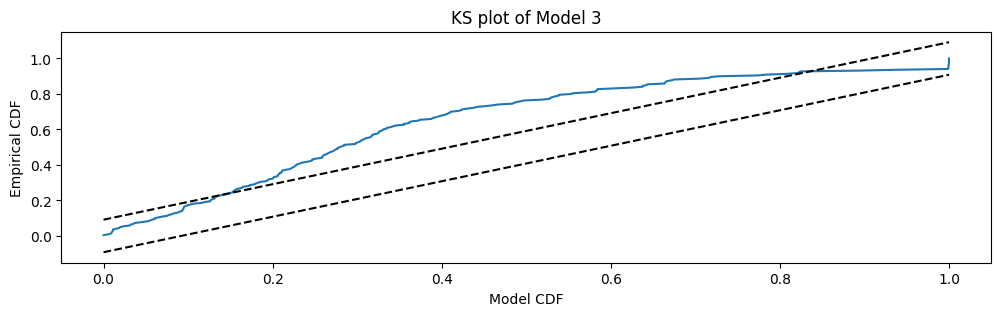

In [43]:
ecdf = ECDF(Z)
mCDF = 1 - exp(-ecdf.x)
N = len(Z)

plot(mCDF, ecdf.y)
plot([0,1], [0,1] + 1.36/sqrt(N),'k--', ms = 2)
plot([0,1], [0,1] - 1.36/sqrt(N),'k--', ms = 2)
xlabel('Model CDF')                 #Label the axes.
ylabel('Empirical CDF')
title('KS plot of Model 3')
show()

Q: ¿Tiene sentido la definición de la CDF del modelo (variable $mCDF$)? Recuerda que, por el teorema del reescalado del tiempo, esperamos que las variables reescaladas

$$
\text{(variables reescaladas)}
$$

provengan de la distribución exponencial con parámetro 1.

Q: Considera el gráfico KS arriba. Según el teorema del reescalado del tiempo, ¿es adecuado el Modelo 3 para los datos?

A: Si los datos de espigas provinieran de un proceso de Poisson con una tasa dada por el modelo 3, entonces esperaríamos que el gráfico KS se mantuviera dentro de los límites de confianza del 95%, o que cualquier desviación de estos límites fuera pequeña. Encontramos que el gráfico KS toma valores muy fuera de los límites de confianza del 95%. Por lo tanto, concluimos que nuestro modelo no está capturando completamente la estructura de los datos de espigas.

Método 5: Análisis de residuos.
Los residuos representan la diferencia entre los datos y la predicción del modelo a nivel de puntos de datos individuales. Mientras que cantidades como la desviación o el gráfico KS son útiles para obtener una visión general de cómo se ajusta el modelo a los datos en su conjunto, el análisis de residuos es esencial para entender qué componentes de un conjunto de datos están bien o mal ajustados por el modelo. Por lo tanto, es una de las mejores herramientas para determinar qué falta en un modelo.

Hay muchos tipos de residuos que se pueden calcular para datos de procesos puntuales (incluidos los residuos crudos, los residuos de Pearson y los residuos de desviación [McCullagh & Nelder, 1989]). No entraremos en detalle sobre las ventajas de cada tipo de residuo. En su lugar, centrémonos en un tipo de residuo que es particularmente útil para datos de espigas: el proceso acumulativo de residuos crudos. En tiempo continuo, calcularíamos este proceso de residuos, $R(t)$, como

$$
R(t) = \text{conteo total de espigas hasta el tiempo } t - \text{modelo de tasa de Poisson en el tiempo } t
$$

Dado que estamos trabajando en tiempo discreto, en cualquier punto de tiempo $t$ calculamos esto como

$$
R(t) = \text{número de espigas observadas en el intervalo de tiempo discreto } t
$$

En Python, calculamos $R(t)$ tomando la suma acumulativa de los residuos crudos, que se devuelven como un atributo de la clase `GLMResults`. Luego, para calcular la suma acumulativa de estos residuos, usamos la función `cumsum()` de la siguiente manera:

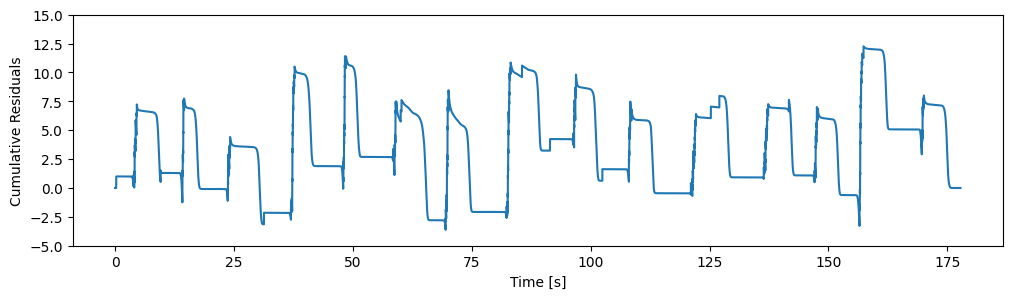

In [44]:
R = cumsum(model3_results.resid_response)
plot(t, R)
ylim(-5, 15)
xlabel('Time [s]')
ylabel('Cumulative Residuals')
show()

Si el Modelo 3 fuera correcto, entonces los residuos deberían tener una media cero y estar no correlacionados con ningún covariable. Vemos en la figura anterior que el proceso acumulativo de residuos termina en cero, lo que sugiere que los residuos suman cero a lo largo de todos los pasos de tiempo. Sin embargo, también identificamos un patrón en el proceso de residuos, lo que sugiere que aún hay alguna estructura en los datos que no está capturada por el Modelo 3. Más específicamente, la inspección visual sugiere una relación entre los residuos y una covariable del modelo: la posición (ver figura generada por el código a continuación). Observamos que el proceso acumulativo de residuos parece aumentar siempre que el ratón se mueve en la dirección positiva y disminuir siempre que el ratón se mueve en la dirección negativa. Este análisis sugiere exactamente lo que ha estado faltando en nuestros modelos: la dirección.

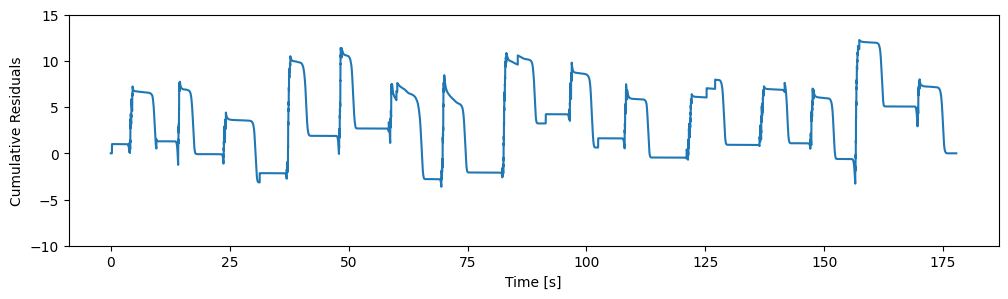

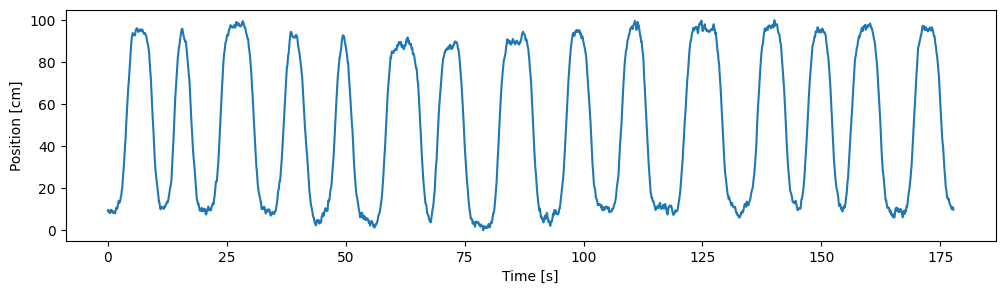

In [45]:
# Comparison of Cumulative residuals over time and rat position over time.
plot(t,R)
ylim(-10, 15)
xlabel('Time [s]')
ylabel('Cumulative Residuals')
show()
plot(t,X)
xlabel('Time [s]')
ylabel('Position [cm]')
show()

### Refinando el Modelo (Continuación)

Nuestro análisis de la bondad de ajuste sugiere que el Modelo 3 proporciona una mejora significativa sobre el Modelo 2. Sin embargo, el análisis del proceso acumulativo de residuos reveló que el Modelo 3 omite una característica esencial de los datos: el Modelo 3 no tiene en cuenta la dependencia del espigueo en la dirección. Por lo tanto, vamos a refinar el modelo incluyendo una nueva covariable que capture la dirección del movimiento del ratón.

Primero debemos definir una función indicadora simple para la dirección del movimiento. Si el valor de $x$ aumentó desde el último paso de tiempo, asignamos a esta variable un valor de 1; de lo contrario, asignamos 0. Para el primer paso de tiempo, no sabemos de qué dirección vino el ratón, por lo que se asigna 0 arbitrariamente.

In [46]:
increasing = where(diff(X.flatten()) > 0)[0]  # Array for if X(t) increased since last step
direction = zeros_like(X)  # Create a direction array the same size as X
direction[increasing] = 1  # Set direction to 1 when X is increasing

Q: ¿Indica la variable `direction` la dirección del movimiento con un 0 o 1, como deseamos? Pista: Considera la función `diff()` y cómo se usa para encontrar momentos en los que $x$ aumenta.

Con la función indicadora para la dirección del movimiento ahora definida, debemos incorporar esta nueva señal en el modelo. La solución más sencilla es agregar la variable `direction` directamente como un nuevo predictor. Esto daría lugar a un nuevo modelo,

$$
\text{firing rate} = \text{exp}(\beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 \text{direction})
$$

Luego ajustamos este modelo e interpretamos las estimaciones de los parámetros. Con nuestra experiencia previa en este cuaderno, ajustar el modelo en Python ahora es relativamente sencillo:

In [47]:
#Fit Model 4, and return estimates and useful statistics.
predictors['direction'] = direction #Add column for direction
# GLM model with Poisson family and default (log) link function
model4 = sm.GLM(spiketrain, predictors, family=Poisson()) 
model4_results = model4.fit()       # Fit model to our data
b4 = model4_results.params          # Get the predicted coefficient vector
print(b4)

Intercept   -28.870275
X             0.688905
X2           -0.005452
direction     3.275282
dtype: float64


Q: ¿Ves cómo, en este código, las tres covariables (posición, posición al cuadrado y dirección) se incluyen como entradas al modelo GLM?

Estamos particularmente interesados en la estimación del parámetro final. Cuando la variable indicadora de dirección es igual a cero—cuando el ratón se mueve en dirección negativa o está parado—este componente no afecta la tasa. Cuando la indicadora de dirección es 1, este componente del modelo modula la tasa en 

Para nuestro parámetro estimado, encontramos que $b_4[3] = 3.2753$ y por lo tanto que 

Q: ¿Cuál es el impacto de la dirección en la tasa de disparo?

A: Bajo este modelo, cuando el ratón se mueve en la dirección positiva, la tasa de disparo es más de 26 veces mayor que la tasa de disparo cuando el animal está detenido o se mueve en la dirección negativa. Dado que solo observamos al ratón el tiempo suficiente para que la célula de lugar dispare unos cientos de picos, esperamos que la mayoría de estos picos ocurran cuando el animal se mueve en la dirección positiva.

Podríamos realizar el mismo cambio de parámetros para este modelo que para la forma alternativa del Modelo 3. Anteriormente, expresamos el Modelo 3 utilizando una media, un ancho y una tasa máxima de disparo para el campo de lugar. Si realizáramos este cambio de parámetros para el Modelo 4, todavía tendríamos solo una media, un ancho y una tasa máxima de disparo, y un parámetro adicional relacionado con la modulación de la dirección, cuyo valor estimado no cambiaría.

Comparando y Evaluando Modelos (Continuación)
Ahora que tenemos un nuevo modelo que intenta capturar la dependencia de los disparos en la dirección del movimiento, comparemos el ajuste del modelo resultante con los ajustes de los modelos anteriores y evaluemos la bondad de ajuste general de este nuevo modelo. Primero, comparamos los valores de AIC entre los Modelos 3 y 4:

In [48]:
dev4 = model4_results.deviance         # Deviance from Model 4
dAIC = (dev3 + 2 * 3) - (dev4 + 2 * 4) # Difference in AIC between Models 3 & 4.
print(dAIC)

233.8694473933117



Q: ¿Por qué usamos los términos $2 \times 3$ para el Modelo 3 y $2 \times 4$ para el Modelo 4?

Encontramos que $dAIC = 233.8806$, una diferencia que es positiva y grande, lo que sugiere una mejora significativa en el ajuste del Modelo 4 en comparación con el Modelo 3. Para evaluar la significancia, podemos realizar nuevamente una MLRT. El Modelo 3 está claramente anidado en el Modelo 4, ya que bajo la hipótesis nula de que $b_4 = 0$, obtenemos el Modelo 3. Dado que solo hay un parámetro que ajustar, la estadística de MLRT tendría una distribución chi-cuadrado con 1 grado de libertad si la hipótesis nula fuera cierta. Así que calculamos el valor p para esta prueba como


In [49]:
p = 1 - chi2.cdf(dev3 - dev4, 1)  # Compare Models 3 and 4, nested GLMs.
print(p)

0.0


y encontramos un valor de $p_{\text{beta4}}$. Nuevamente, observamos que la adición de un parámetro conduce a una mejora altamente significativa en el ajuste a los datos.

A continuación, calculemos el intervalo de confianza y la significancia para el parámetro $b_4$:


In [50]:
# For Model 4, compute 95% CI for last parameter,
CI_beta3 = [b4[3] - 2*model4_results.bse[3], b4[3] + 2*model4_results.bse[3]]
p_beta3 = model4_results.pvalues[3]  # and significance level.
print('CI_beta3: ', CI_beta3)
print('p_beta3: ', p_beta3)

CI_beta3:  [2.5549560544170506, 3.9956073965372165]
p_beta3:  9.555627447272083e-20



Encontramos que el intervalo de confianza ($\text{CI}_{\text{beta4}} = [2.5550, 3.9957]$) no contiene el valor cero y es altamente significativamente diferente de cero ($p_{\text{beta4}} = 9.5422 \times 10^{-20}$). Estos análisis de bondad de ajuste se corroboran entre sí al sugerir que la inclusión del término de dirección proporciona una mejora significativa en la captura de la estructura de espiking observada.

A continuación, investigaremos la bondad de ajuste general de este modelo utilizando el teorema de reescalamiento temporal y construyendo un gráfico KS.

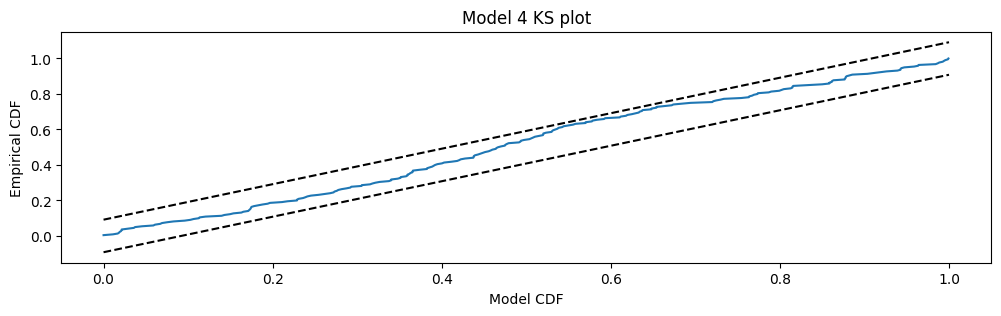

In [51]:
lambda4 = exp(b4[0] + b4[1]*X + b4[2]*X**2 + b4[3]*direction)

Z = [sum(lambda4[a:b])  # Compute the rescaled waiting time
     for a, b in zip(hstack((0, spikeindex[:-1])), spikeindex)]  # ... for each spike interval

ecdf = ECDF(Z)                                   # Define empirical cdf
mCDF = 1 - exp(-ecdf.x)                          # ... and model cdf

plot(mCDF, ecdf.y)                               # create KS plot 
plot([0,1], [0,1]+1.36/sqrt(N),'k--', ms = 2)    # Upper confidence bound
plot([0,1], [0,1]-1.36/sqrt(N),'k--', ms = 2)    # Lower confidence bound
xlabel('Model CDF')                              # Label the axes.
ylabel('Empirical CDF')
title('Model 4 KS plot')
show()


El gráfico KS para el Modelo 4 se ve mucho mejor que el que construimos para el Modelo 3. Notamos que el gráfico KS para el Modelo 4 se mantiene dentro de los límites del 95% en todas partes, a diferencia del gráfico KS para el Modelo 3. Esto no significa que el modelo sea correcto, pero no hay evidencia significativa de falta de ajuste según el gráfico KS.

Finalmente, calculemos y examinemos el proceso de residuos acumulativos:

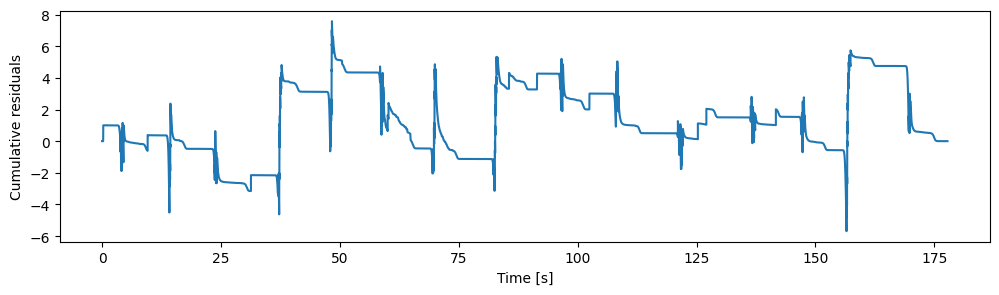

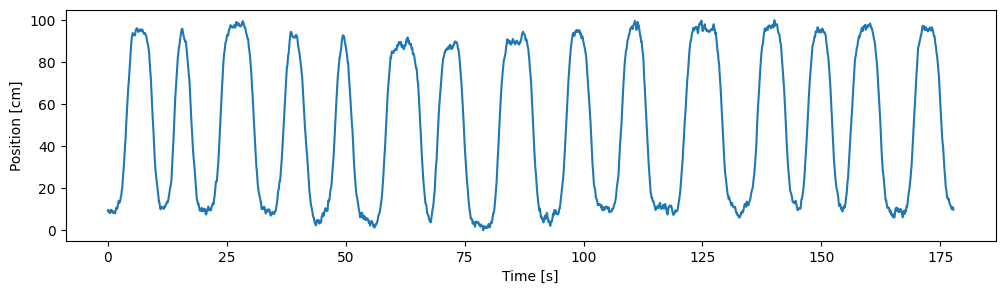

In [52]:
R = cumsum(model4_results.resid_response)  # Cumulative sum of Model 4 residuals.
plot(t,R)                                  # Plot it.
xlabel('Time [s]')
ylabel('Cumulative residuals')
show()

plot(t, X)
xlabel('Time [s]')
ylabel('Position [cm]')
show()


La figura anterior muestra el proceso de residuos acumulativos para el Modelo 4 y la trayectoria de movimiento. Encontramos que el proceso de residuos ahora está centrado en cero. Aún puede haber algo de estructura en función del tiempo, pero ya no está tan estrechamente asociado con la trayectoria de movimiento como en el Modelo 3.

## Sacando Conclusiones del Modelo

Es probable que pudiéramos refinar aún más este modelo, quizás añadiendo covariables adicionales o incluyendo una estructura de dependencia diferente en las covariables que estamos utilizando actualmente. El proceso de refinamiento del modelo no se trata de identificar un único modelo correcto. En su lugar, se trata de construir un modelo que capture adecuadamente las características de los datos que nos interesan. Para este análisis, decidamos que, basándonos en nuestras múltiples herramientas de ajuste del modelo, el Modelo 4 es suficientemente bueno. Ahora utilizamos este modelo para comprender mejor la estructura de la célula de lugar que generó estos datos.

El proceso de refinamiento y comparación del modelo nos ha ayudado a identificar características importantes del campo receptivo de esta neurona. Desde las visualizaciones iniciales, era claro que la actividad de disparo de esta neurona es sensible a la posición; es más probable que dispare cuando el animal se encuentra en ciertas posiciones que en otras. Nuestro análisis de modelado mostró además que esta dependencia de la posición podría describirse bien mediante una función cuadrática exponencial de la posición, es decir, una función con forma de gaussiana.

Ahora estimemos los parámetros para el centro, el ancho y la tasa máxima de disparo de este campo de lugar. Para ello, utilizamos las expresiones derivadas para la forma alternativa del Modelo 3. Calculando estos valores para las estimaciones del Modelo 4 (variable b4),

In [53]:
#For Model 4, compute maximum likelihood estimates of
mu = -b4[1] / (2 * b4[2])                 # place field center
sigma = sqrt(-1 / (2 * b4[2]))            # place field size
alpha = exp(b4[0] - b4[1]**2 / (4 * b4[2]))  # max firing rate

print('mu: ', mu)
print('sigma: ', sigma)
print('alpha: ', alpha)

mu:  63.184400829806656
sigma:  9.576905113790856
alpha:  0.0008199709288916105


**P:** Interpreta los valores que has calculado. ¿Qué encuentras?

**R:** El campo de lugar está centrado aproximadamente a 63 cm a lo largo de la pista (mu = 63.18), y la mayor parte de la actividad de disparo ocurre en una región de aproximadamente 19 cm (sigma = 9.58, por lo que 2 * sigma = 19.16). Inicialmente, el valor de la tasa máxima de disparo de aproximadamente alpha = 8.2e-4 spikes/ms, o 0.8 spikes/s parece demasiado bajo, hasta que nos damos cuenta de que esta es la tasa máxima solo cuando dir=0. Cuando dir=1, se multiplica por exp(b4[3])=26.451. La tasa máxima de disparo cuando el ratón se mueve en la dirección positiva es de aproximadamente 26 spikes/s.

Ahora visualicemos la tasa de disparo en función de la posición y la dirección. Usamos la función `predict` para esto. Esta función utiliza tanto las estimaciones de parámetros como la estructura de estadísticas que se genera al ajustar el modelo (`fit`), y calcula la función de tasa de Poisson estimada.

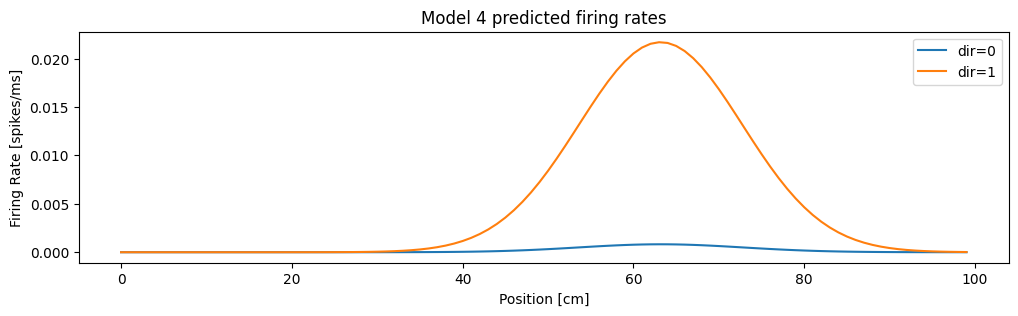

In [54]:
xs = arange(100)

# Create an array with [constant, position, position squared, direction] terms
dir_0 = array([ones_like(xs), xs, xs**2, zeros_like(xs)]).T  # ... for when the direction is 0
dir_1 = array([ones_like(xs), xs, xs**2, ones_like(xs)]).T  # ... and for when direction is 1
lambda4_0 = model4_results.predict(dir_0)  # Predict the firing rate when the direction is 0
lambda4_1 = model4_results.predict(dir_1)  # ... and when the direction is one

plot(xs, lambda4_0, label="dir=0")  # Plot results
plot(xs, lambda4_1, label="dir=1")
xlabel('Position [cm]')
ylabel('Firing Rate [spikes/ms]')
title('Model 4 predicted firing rates')
legend()
show()

**P:** Considera las entradas a la función `predict()` en este código. ¿Cómo se definen las covariables de posición, posición al cuadrado y dirección? ¿Qué distingue al Modelo 4 evaluado para posiciones crecientes versus posiciones decrecientes?

**P:** Considera la función de tasa de Poisson estimada frente a la covariable de posición para el Modelo 4 que se muestra en la figura anterior. ¿Cómo varía la tasa de disparo con la posición y la dirección?

**R:** La inspección de la figura revela que la tasa de disparo depende tanto de la posición como de la dirección. La tasa es mayor cerca de la posición de 63 cm y cuando la posición está aumentando. Cuando la posición está disminuyendo, el aumento en la tasa cerca de la posición de 63 cm es mucho menor. Estos resultados del Modelo 4, evaluados utilizando parámetros ajustados a los datos observados, son consistentes con nuestras visualizaciones iniciales de los datos.

También podemos sacar algunas conclusiones sobre los datos a partir de elementos que no están en el modelo ajustado. Como discutimos en el cuaderno 10, la característica definitoria de los modelos de Poisson es que no tienen estructura dependiente de la historia; la probabilidad de un espín en cualquier momento puede depender de una variedad de factores, pero no depende de los espines pasados. El hecho de que hayamos logrado un buen ajuste (basado en el análisis del gráfico KS) con un modelo de Poisson sugiere que la dependencia del espín pasado no es necesaria para capturar gran parte de la estructura estadística esencial en los datos. De manera similar, otras covariables, como la velocidad de movimiento, no eran necesarias para capturar la estructura del campo de lugar de esta neurona. La neurona aún puede codificar estas variables; sin embargo, podemos describir la estructura de espín en términos de otras variables.

**Resumen**

En este estudio de caso, utilizamos un proceso iterativo para identificar un modelo estadístico para una célula del campo de lugar del hipocampo. Comenzamos visualizando los datos, luego propusimos modelos de procesos puntuales, comparamos y evaluamos esos modelos, refinamos los modelos y, finalmente, sacamos conclusiones de un modelo que capturó suficientemente la estructura en los datos que intentábamos explicar. Cada paso de este procedimiento debe informar al siguiente. El objetivo del análisis de visualización es identificar covariables y estructuras del campo receptivo para incluir en los primeros modelos propuestos. El análisis de bondad de ajuste debe proporcionar información sobre las características del modelo estadístico que faltan y sugerir nuevos modelos. En este estudio de caso, nos decidimos por un buen modelo después de solo dos iteraciones de refinamiento del modelo. En la práctica, puede que se necesiten muchas más iteraciones —o incluso iteraciones entre la identificación del modelo y nuevos experimentos— para identificar buenos modelos.

Cabe señalar que más de la mitad de este estudio de caso está dedicado a la interpretación del modelo y los métodos de bondad de ajuste. Esto es común en los análisis estadísticos avanzados; ajustar modelos a datos suele ser la parte fácil. El desafío a menudo radica en interpretar y evaluar los resultados del procedimiento de ajuste. Dado que no hay una única forma correcta de evaluar un modelo, usamos una variedad de herramientas para evaluar múltiples aspectos de la calidad del modelo. Aquí nos enfocamos en algunas que son generalmente útiles para datos de procesos puntuales y para modelado de Poisson en particular. En el próximo cuaderno, veremos métodos adicionales de bondad de ajuste, en particular, aquellos para captar la dependencia de la historia y la ritmicidad en los datos de espín.